In [85]:
import pandas as pd 
import re
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet
import keras
import tensorflow as tf
from imblearn.over_sampling import SMOTE
import spacy
import tqdm
import numpy as np
import json
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Honda\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Read_data 

In [86]:
df = pd.read_json("News_Dataset.json",orient='columns', lines=True)

df=df[['category','headline','short_description']]

In [87]:
df.head()

,category,headline,short_description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,She left her husband. He killed their children...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Of course it has a song.
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,The actor and his longtime girlfriend Anna Ebe...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,The actor gives Dems an ass-kicking for not fi...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,"The ""Dietland"" actress said using the bags is ..."


In [88]:
df['text']=df['headline']+' '+df['short_description']

In [89]:
df=df[['category','text']]

In [90]:
df.head()

,category,text
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...


In [91]:
from sklearn.preprocessing import LabelEncoder
LE=LabelEncoder()
LE.fit(df['category'])
df['category']=LE.transform(df['category'])

In [92]:
df

,category,text
0,6,There Were 2 Mass Shootings In Texas Last Week...
1,10,Will Smith Joins Diplo And Nicky Jam For The 2...
2,10,Hugh Grant Marries For The First Time At Age 5...
3,10,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,10,Julianna Margulies Uses Donald Trump Poop Bags...
...,...,...
200848,32,RIM CEO Thorsten Heins' 'Significant' Plans Fo...
200849,28,Maria Sharapova Stunned By Victoria Azarenka I...
200850,28,"Giants Over Patriots, Jets Over Colts Among M..."
200851,28,Aldon Smith Arrested: 49ers Linebacker Busted ...


# EDA

In [93]:
df.shape

(200853, 2)

In [94]:
len(df['category'].unique())

41

In [95]:
#df=df.iloc[:100000,:]

In [96]:
df.shape

(200853, 2)

Class_counts

In [97]:
df['category'].value_counts()

24    32739
37    17827
10    16058
34     9887
30     9649
22     8677
16     6694
25     6314
13     6226
3      5937
5      5175
28     4884
2      4528
17     4195
23     3955
33     3664
35     3651
38     3490
18     3459
8      3426
6      3405
20     2815
36     2670
15     2622
40     2579
26     2556
29     2254
27     2178
39     2177
31     2096
32     2082
21     1707
0      1509
12     1401
14     1398
1      1339
11     1323
4      1144
19     1129
7      1030
9      1004
Name: category, dtype: int64

Check_for_nans

In [98]:
df.isna().any()

category    False
text        False
dtype: bool

Check for duplicates

In [99]:
df.duplicated().any()

True

In [100]:
df.drop_duplicates(inplace=True)

# Preprocessing

In [101]:
df['text'].sample(4)

10089     Will Ferrell Breaks Into The Kardashian House ...
197766    My Kids Will Cost Me Close to a Million Dollar...
88493     Experts: What Nepal Needs Most To Stem Baby De...
121965        Apparently This Is Hollywood's Richest Actor 
Name: text, dtype: object

check for mails

In [102]:
df['text'].apply(lambda x: re.findall('\S+@\S+',x)).any()

True

In [103]:
df['text']=df['text'].apply(lambda x: re.sub('\S+@\S+',' ',x))

check for websites

In [104]:
df['text'].apply(lambda x: re.findall(r'http\S+',x)).any()

True

In [105]:
df['text']=df['text'].apply(lambda x: re.sub(r'http\S+',' ',x))

remove non char signs

In [106]:
df['text']= df['text'].apply(lambda x : re.sub(r'[^A-Za-z0-9]', ' ', x))
df['text']

0         There Were 2 Mass Shootings In Texas Last Week...
1         Will Smith Joins Diplo And Nicky Jam For The 2...
2         Hugh Grant Marries For The First Time At Age 5...
3         Jim Carrey Blasts  Castrato  Adam Schiff And D...
4         Julianna Margulies Uses Donald Trump Poop Bags...
                                ...                        
200848    RIM CEO Thorsten Heins   Significant  Plans Fo...
200849    Maria Sharapova Stunned By Victoria Azarenka I...
200850    Giants Over Patriots  Jets Over Colts Among  M...
200851    Aldon Smith Arrested  49ers Linebacker Busted ...
200852    Dwight Howard Rips Teammates After Magic Loss ...
Name: text, Length: 200383, dtype: object

Normalize_words

In [107]:
df['text']=df['text'].apply(lambda x:x.lower())
df['text']

0         there were 2 mass shootings in texas last week...
1         will smith joins diplo and nicky jam for the 2...
2         hugh grant marries for the first time at age 5...
3         jim carrey blasts  castrato  adam schiff and d...
4         julianna margulies uses donald trump poop bags...
                                ...                        
200848    rim ceo thorsten heins   significant  plans fo...
200849    maria sharapova stunned by victoria azarenka i...
200850    giants over patriots  jets over colts among  m...
200851    aldon smith arrested  49ers linebacker busted ...
200852    dwight howard rips teammates after magic loss ...
Name: text, Length: 200383, dtype: object

Remove_stop_words

In [108]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Honda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [109]:
stop_words=stopwords.words('english')

In [110]:
df['text']=df['text'].apply(lambda x :[ word for word in x.split() if word not in stop_words])


In [111]:
df['text']

0         [2, mass, shootings, texas, last, week, 1, tv,...
1         [smith, joins, diplo, nicky, jam, 2018, world,...
2         [hugh, grant, marries, first, time, age, 57, a...
3         [jim, carrey, blasts, castrato, adam, schiff, ...
4         [julianna, margulies, uses, donald, trump, poo...
                                ...                        
200848    [rim, ceo, thorsten, heins, significant, plans...
200849    [maria, sharapova, stunned, victoria, azarenka...
200850    [giants, patriots, jets, colts, among, improba...
200851    [aldon, smith, arrested, 49ers, linebacker, bu...
200852    [dwight, howard, rips, teammates, magic, loss,...
Name: text, Length: 200383, dtype: object

In [112]:
pos_tags = [wordnet.VERB, wordnet.NOUN, wordnet.ADJ, wordnet.ADV]
lemmatizer = WordNetLemmatizer()
for pos in pos_tags:
   df['text']=df['text'].apply(lambda x:[lemmatizer.lemmatize(word, pos=pos) for word in x])

In [113]:
df['text']

0         [2, mass, shoot, texas, last, week, 1, tv, lea...
1         [smith, join, diplo, nicky, jam, 2018, world, ...
2         [hugh, grant, marry, first, time, age, 57, act...
3         [jim, carrey, blast, castrato, adam, schiff, d...
4         [julianna, margulies, use, donald, trump, poop...
                                ...                        
200848    [rim, ceo, thorsten, heins, significant, plan,...
200849    [maria, sharapova, stun, victoria, azarenka, a...
200850    [giant, patriot, jet, colt, among, improbable,...
200851    [aldon, smith, arrest, 49ers, linebacker, bust...
200852    [dwight, howard, rip, teammate, magic, loss, h...
Name: text, Length: 200383, dtype: object

In [114]:
df['text']=df['text'].apply(lambda x: ' '.join(x))

In [115]:
df['text']

0         2 mass shoot texas last week 1 tv leave husban...
1         smith join diplo nicky jam 2018 world cup offi...
2         hugh grant marry first time age 57 actor longt...
3         jim carrey blast castrato adam schiff democrat...
4         julianna margulies use donald trump poop bag p...
                                ...                        
200848    rim ceo thorsten heins significant plan blackb...
200849    maria sharapova stun victoria azarenka austral...
200850    giant patriot jet colt among improbable super ...
200851    aldon smith arrest 49ers linebacker bust duo c...
200852    dwight howard rip teammate magic loss hornet f...
Name: text, Length: 200383, dtype: object

# Split_data

In [116]:
from sklearn.model_selection import train_test_split
target=df['category']
x_train, x_test ,y_train ,y_test = train_test_split(df['text'],target,test_size=0.1,stratify=target)

In [117]:
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

# Modeling

# Tokenizer+GRUArchitecture

In [118]:
tokenizer=Tokenizer(num_words=10000,oov_token='<OOV>',)
tokenizer.fit_on_texts(x_train)

In [119]:
tokenizer.word_index

{'<OOV>': 1,
 'say': 2,
 'new': 3,
 'trump': 4,
 'make': 5,
 'get': 6,
 'one': 7,
 'year': 8,
 'u': 9,
 'time': 10,
 'photo': 11,
 'day': 12,
 'people': 13,
 'like': 14,
 'go': 15,
 'take': 16,
 'know': 17,
 'way': 18,
 'woman': 19,
 'want': 20,
 'good': 21,
 'life': 22,
 'world': 23,
 'look': 24,
 'need': 25,
 'love': 26,
 'find': 27,
 'think': 28,
 'thing': 29,
 'first': 30,
 'come': 31,
 'live': 32,
 'video': 33,
 'show': 34,
 'child': 35,
 'week': 36,
 'best': 37,
 'see': 38,
 'work': 39,
 'help': 40,
 'may': 41,
 'would': 42,
 'could': 43,
 'right': 44,
 'donald': 45,
 'even': 46,
 'many': 47,
 'give': 48,
 'kid': 49,
 'state': 50,
 'american': 51,
 'back': 52,
 'change': 53,
 'use': 54,
 'call': 55,
 'old': 56,
 'president': 57,
 'family': 58,
 'health': 59,
 'two': 60,
 'big': 61,
 'home': 62,
 'feel': 63,
 'tell': 64,
 'parent': 65,
 'last': 66,
 'much': 67,
 'long': 68,
 'food': 69,
 'still': 70,
 '10': 71,
 'really': 72,
 '5': 73,
 'great': 74,
 'house': 75,
 'every': 76,
 's

In [120]:
vocab_siz=len(tokenizer.word_index)
vocab_siz

64810

In [121]:
x_train_tokenized=tokenizer.texts_to_sequences(x_train)
x_test_tokenized=tokenizer.texts_to_sequences(x_test)

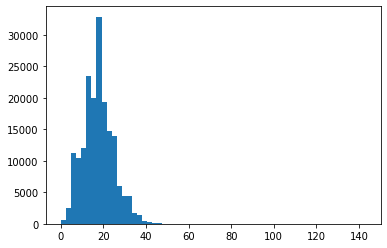

In [122]:
import matplotlib.pyplot as plt
plt.hist([len(s) for s in x_train_tokenized],bins=60);

In [123]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train_padded=pad_sequences(x_train_tokenized, maxlen=50, padding='post',truncating='post')
x_test_padded=pad_sequences(x_test_tokenized, maxlen=50, padding='post',truncating='post')

In [124]:
model=tf.keras.models.Sequential([
    
    tf.keras.layers.Embedding(vocab_siz+1,128),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,return_sequences=True,recurrent_dropout=0.1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(41, activation='softmax')   
])

In [125]:
from tensorflow.keras.optimizers import RMSprop,Adam
model.compile(optimizer= Adam(lr=0.0005),
              loss= keras.losses.categorical_crossentropy,
              metrics= [keras.metrics.AUC()])

C:\Users\Honda\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.fit(x_train_padded,train_labels,epochs=5,validation_data=(x_test_padded,test_labels))

Epoch 1/5
5636/5636 [==============================] - 2280s 403ms/step - loss: 1.9338 - auc_2: 0.9225 - val_loss: 1.5514 - val_auc_2: 0.9494
Epoch 2/5
5636/5636 [==============================] - 1580s 280ms/step - loss: 1.3767 - auc_2: 0.9596 - val_loss: 1.3648 - val_auc_2: 0.9597
Epoch 3/5
5636/5636 [==============================] - 1583s 281ms/step - loss: 1.1908 - auc_2: 0.9693 - val_loss: 1.3176 - val_auc_2: 0.9613
Epoch 4/5
5636/5636 [==============================] - 1750s 310ms/step - loss: 1.0670 - auc_2: 0.9748 - val_loss: 1.3347 - val_auc_2: 0.9587
Epoch 5/5
3459/5636 [=================>............] - ETA: 11:36 - loss: 0.9395 - auc_2: 0.9799

# GLOVE features+LSTM architecture

In [ ]:
! pip install -U spacy
! python -m spacy download en_core_web_md
import spacy

In [ ]:
x_train_v = np.zeros((len(x_train), 300))
x_test_v = np.zeros((len(x_test), 300))

for i, doc in tqdm(enumerate(nlp.pipe(x_train)), total=len(x_train)):
    x_train_v[i, :] = doc.vector

for i, doc in tqdm(enumerate(nlp.pipe(x_test)), total=len(x_test)):
    x_test_v[i, :] = doc.vector

In [ ]:
x_train_padded=pad_sequences(x_train_v, maxlen=50, padding='post',truncating='post')
x_test_padded=pad_sequences(x_test_v, maxlen=50, padding='post',truncating='post')

In [ ]:
model_2=tf.keras.models.Sequential([
    
    tf.keras.layers.Embedding(vocab_siz+1,64),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,return_sequences=True,recurrent_dropout=0.1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(41, activation='softmax')   
])

In [ ]:
from tensorflow.keras.optimizers import RMSprop,Adam
model_2.compile(optimizer= Adam(),
              loss= keras.losses.categorical_crossentropy,
              metrics= [keras.metrics.AUC()])

In [ ]:
model_2.fit(x_train_padded,train_labels,epochs=5,validation_data=(x_test_padded,test_labels))

In [1]:
def predict(text,model, padding_size):
  tokenized_text=tokenizer.texts_to_sequences(text)
  padded_text=pad_sequences(tokenized_text, maxlen=padding_size, padding='post',truncating='post')
  predicton = np.argmax(model.predict(X), axis=-1) 
  return prediction

In [2]:
text=.sample(1)
padding_size=50
predict(text,model_2,padding_size)

NameError: name 'x_test' is not defined